# Bayesian Networks

In [18]:
import pymc3 as pm
import arviz as az
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams

%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['text.color'] = 'G'
rcParams['figure.figsize'] = 16,8

# Lets flip coins!

In [37]:
np.random.seed(1337)
trials = 40
theta_real = .35    # unknown value in a real experiment
data = stats.bernoulli.rvs(p = theta_real, size=trials)

In [38]:
data.sum()/len(data)

0.275

## The Model

<img src="Bernoulli-model.png" alt="Krusche Diagram of Bernoulli Model" style="width: 800px;"/>

In [39]:
with pm.Model() as our_first_model:
    Θ = pm.Beta('Θ', alpha=1., beta =1.)
    y = pm.Bernoulli('y', p=Θ, observed = data)
    trace = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Θ]
Sampling 4 chains, 0 divergences: 100%|██████████| 14000/14000 [00:06<00:00, 2049.49draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019E2695A608>,
      dtype=object)

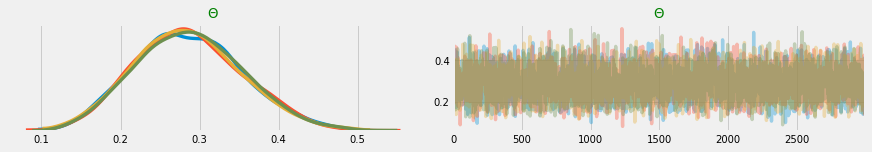

In [40]:
az.plot_trace(trace)

In [41]:
az.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Θ,0.287,0.069,0.158,0.412,0.001,0.001,4648.0,4648.0,4624.0,7526.0,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000019E1FA09208>],
      dtype=object)

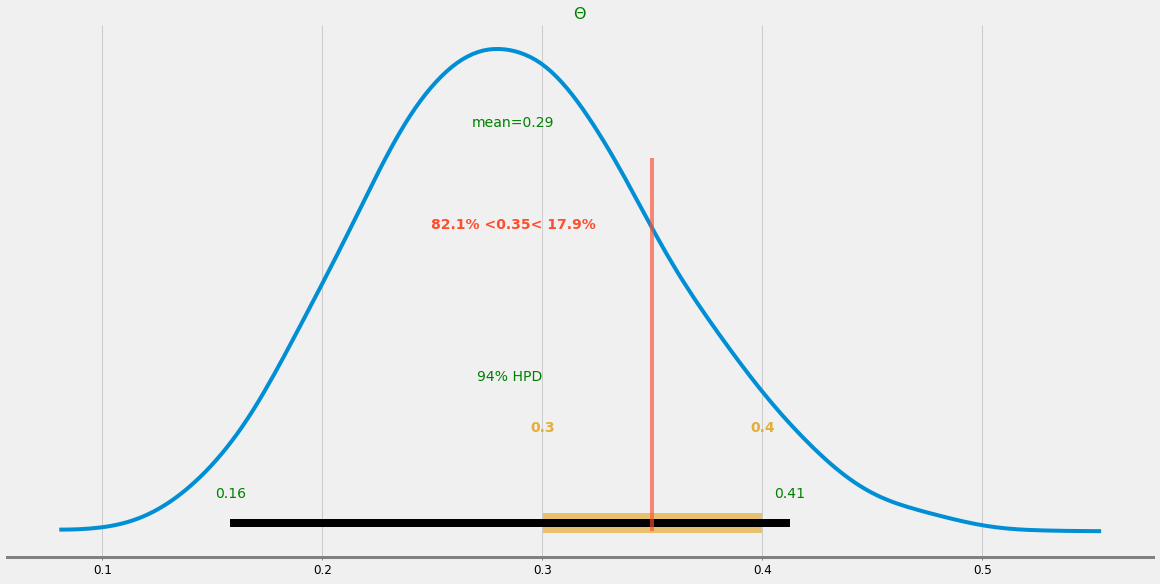

In [47]:
az.plot_posterior(trace, rope=[.3, .4], ref_val=theta_real)

# Advanced Example: Latent Variable Implementation

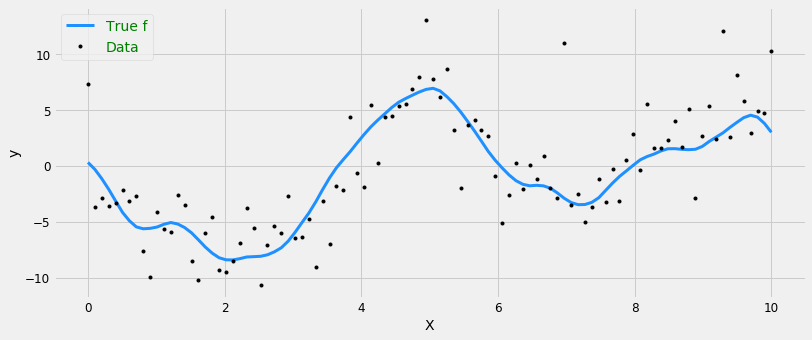

In [19]:
n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
σ_true = 2.0
ν_true = 3.0
y = f_true + σ_true * np.random.standard_t(ν_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

# Coding the model in PyMC3

In [25]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)

    σ = pm.HalfCauchy("σ", beta=5)
    ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0/σ, nu=ν, observed=y)

    trace = pm.sample(1000, chains=1)   #doesnt run multicore due to missing serializability of fortran objects

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ν, σ, f_rotated_, η, ℓ]
Sampling chain 0, 0 divergences: 100%|██████████| 1500/1500 [02:30<00:00,  9.98it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


## Results

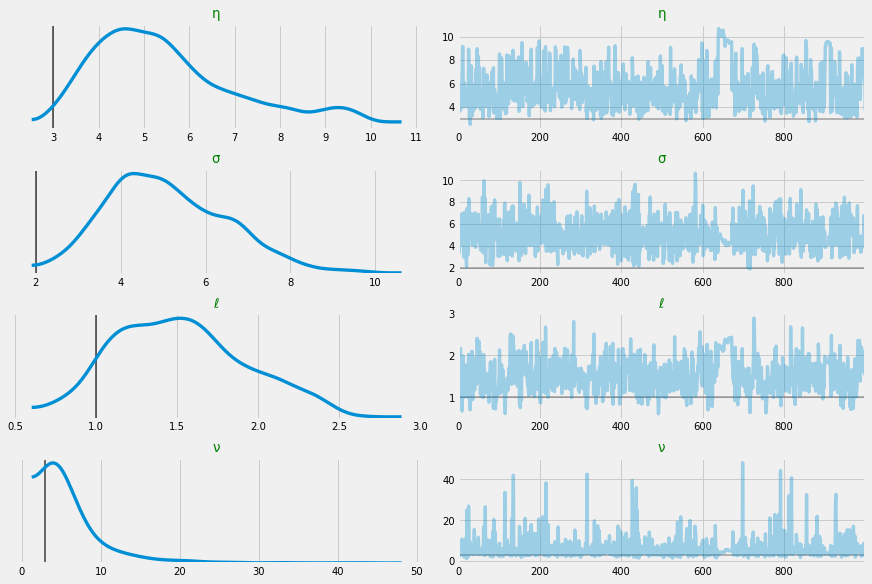

In [26]:
lines = [
    ("η",  {}, η_true),
    ("σ", {}, σ_true),
    ("ℓ", {}, ℓ_true),
    ("ν", {}, ν_true),
]
pm.traceplot(trace, lines=lines, var_names=["η", "σ", "ℓ", "ν"]);

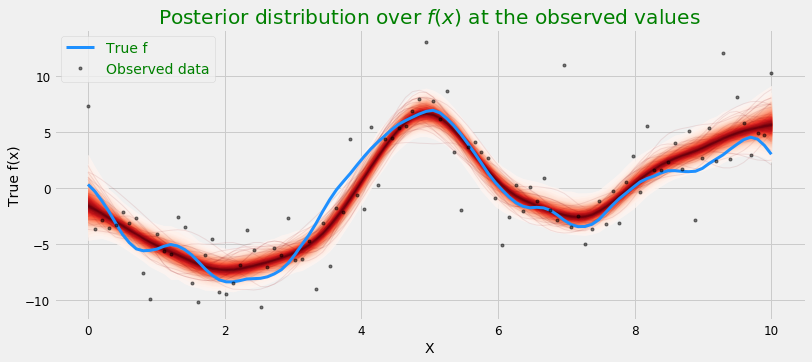

In [27]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, trace["f"], X);

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

## Extend the model

We extend the model by adding the conditional distribution to enable extrapolating/forecasting

In [28]:
n_new = 200
X_new = np.linspace(0, 15, n_new)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=1000)

100%|██████████| 1000/1000 [00:28<00:00, 34.72it/s]


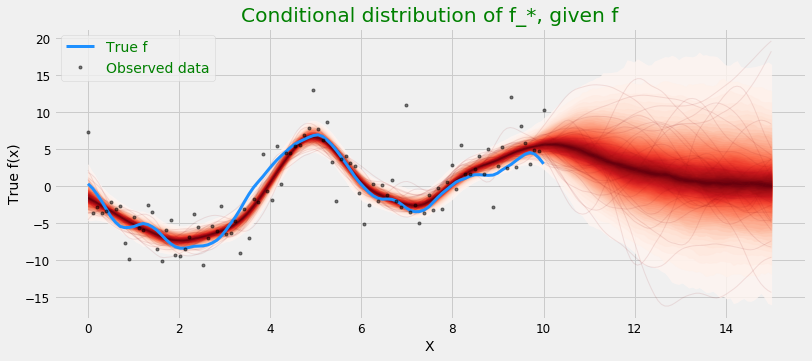

In [29]:
# plot the results

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new);
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Conditional distribution of f_*, given f"); plt.legend();